# Assignment 2

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import graphviz as gr
import statsmodels.formula.api as smf
random.seed(10)

In [2]:
def fn_variance(data, ddof=0):
    m = len(data)
    mean = sum(data)/n
    return sum((x-mean) ** 2 for x in data) / (n - ddof) 

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [3]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err  # Outcome equation
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    """
    tau - treatment effect
    Nrange - range of samle sizes
    p - number of covariates generated
    p0(int): number of covariates with nonzero coefficients
    corr - correlation between covariates
    conf - confounder
    """
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            "No X's included"
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:int(p0/2)]
            Xobs2 = X[:,-int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    # plots x against y
    # the label is what comes out in the legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    # axhline is a horizontal line at the true value of tau
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    # fill confidence interval
    # alpha is the opacity of the fill
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1. Experiments with treatment and covariates in the DGP

 $y_i = \tau*T_i+\beta'*x_i+e_i$
 ### a. Don't control covariates:

In [4]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:02<00:00, 165.17it/s]


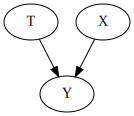

In [4]:
### Use Dag to illustrate the DGP
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X𝑖", "Y")
g


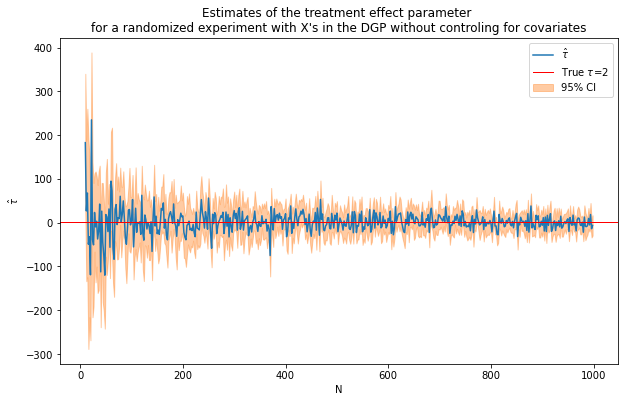

In [6]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP without controling for covariates"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

### b. Control for all the covariates:

In [7]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:03<00:00, 113.31it/s]


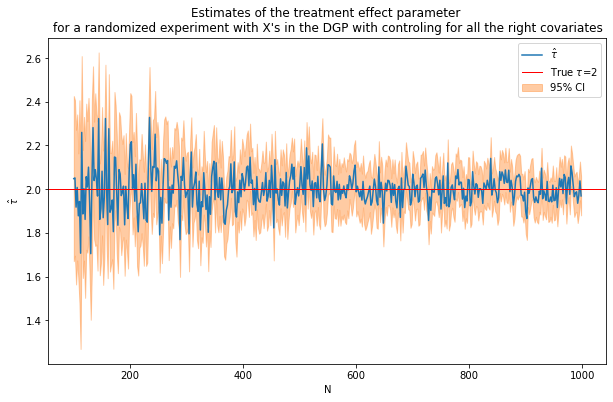

In [8]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP with controling for all the right covariates"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

### Using a Monte Carlo experiment with sample sizes N=100 and N=1000, show the bias, RMSE and size of my treatment effect estimate in cases a and b.

#### (1). The Bias, RMSE and size of treatement effect in case a (not control coveriates)

In [9]:
random.seed(10)
flagX = False
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(2,N,100,50,.5,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:10<00:00, 93.69it/s]


In [10]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-2.0788464845055015, RMSE=35.82688471216658, size=0.049
N=1000: bias=-0.46248257419894717, RMSE=11.646885743638673, size=0.05


#### (2). The Bias, RMSE and size of treatement effect in case b (control for all the coveriates)

In [11]:
random.seed(10)
flagX = 1
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(2,N,100,50,.5,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:13<00:00, 71.57it/s]


In [12]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0042254760178991125, RMSE=0.2036989211911728, size=0.071
N=1000: bias=0.00015272882326959424, RMSE=0.04578640619621463, size=0.044


### Example of a real-life situation

From above Monte Carlo experiment, we could find that when we generate data with treatment varaible and other covariates, if we control for the covariates, the bias and root mean squared error are smaller than the situation of without controling for covariates. So it's a good control. There are many real life situations like it, for example, there are many covariates like education level, background, sex, age, tenure would affect the wage, but you design an experiment that only study the relationship between wage and vocational training(treatment variable) without control other variables that have potential effect on wage, the average treatment effect in this case would be biased.

## 2. Experiments with a confounder in the DGP


 ### a. Fail to control confounder:

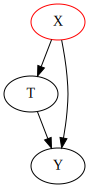

In [5]:
## X means confounder
g = gr.Digraph()
g.node("X", color="red")
g.edge("T", "Y")
g.edge("X", "T")
g.edge("X", "Y")
g

In [198]:
def fn_run_experiments2(tau,Nrange,a,b):
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        e = np.random.normal(0,1,[N,1])
        X = np.random.uniform(0,100,[N,1])
        T = fn_randomize_treatment(N)*a*X+e
        Y = tau*T+b*X+e
        const = np.ones([N,1])
        covars = np.concatenate([T,const],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]    
    return (n_values,tauhats,sehats,lb,ub)

In [199]:
tau = 2
a = 4
b = 1.2
Nrange = range(100,1000,2)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments2(tau,Nrange,a,b)

100%|██████████| 450/450 [00:00<00:00, 484.05it/s] 


### b. Control for a confounder:

In [162]:
def fn_run_experiments3(tau,Nrange,a,b):
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        e = np.random.normal(0,1,[N,1])
        X = np.random.uniform(0,100,[N,1])
        T = fn_randomize_treatment(N)*a*X+e
        Y = tau*T+b*X+e
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]    
    return (n_values,tauhats,sehats,lb,ub)

In [163]:
tau = 2
a = 4
b = 1.2
Nrange = range(100,1000,2)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments3(tau,Nrange,a,b)

100%|██████████| 450/450 [00:01<00:00, 444.31it/s] 


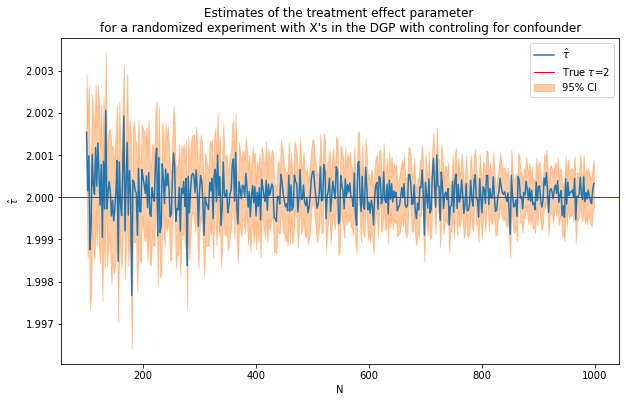

In [164]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP with controling for confounder"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

### Using a Monte Carlo experiment with sample sizes N=100 and N=1000, show the bias, RMSE and size of my treatment effect estimate in cases a and b.

#### (1). The Bias, RMSE and size of treatement effect in case a (not control confounder)

In [172]:
random.seed(10)
tau = 2
a = 4
b = 1.2
R = 1000
estDict = {}
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        e = np.random.normal(0,1,[N,1])
        X = np.random.uniform(0,200,[N,1])
        T = fn_randomize_treatment(N)*0.6*X+e
        Y = tau*T+b*X+e
        const = np.ones([N,1])
        covars = np.concatenate([T,const],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]    
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 209.92it/s]


In [173]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.7921691097601851, RMSE=0.800628483283479, size=1.0
N=1000: bias=0.7972578328169149, RMSE=0.7980962383476401, size=1.0


#### (2). The Bias, RMSE and size of treatement effect in case b (control for a confounder)

In [185]:
random.seed(10)
tau = 2
a = 4
b = 1.2
R = 1000
estDict = {}
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        e = np.random.normal(0,1,[N,1])
        X = np.random.uniform(0,100,[N,1])
        T = fn_randomize_treatment(N)*a*X+e
        Y = tau*T+b*X+e
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]    
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 176.99it/s]


In [184]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=4.2802975391394546e-05, RMSE=0.0007113750758119729, size=0.062
N=1000: bias=5.632081842495618e-05, RMSE=0.00023049999785877982, size=0.064


### Example of a real-life situation

From above Monte Carlo experiment, we could find that when we generate data with treatment varaible and a confounder, if we do not control for the confounder, the bias and root mean squared error are higher than the situation of controling for confounder. So it's a useful control.There are many real life situations like it, for example, if we collect data on sunburns and ice cream consumption. We could find that higher ice cream consumption is associated with a higher probability of sunburn. Does that mean ice cream consumption causes sunburn? The answer is NO. Here, the confounding variable is temperature: hot temperatures cause people to both eat more ice cream and spend more time outdoors under the sun, resulting in more sunburns.So once we control hot temperatures, the bias is eliminated  and our experiment can correctly reflect the relationship between the ice cream consumption and the number of sunburn.

## 3. Experiments with selection bias into the treatment in the DGP


 ### a. Control for the variable in between the path from cause to effect:

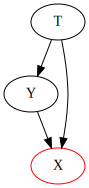

In [6]:
# Control for X would generate selection bias
g = gr.Digraph()
g.edge("T", "Y")
g.edge("Y", "X")
g.edge("T", "X")
g.node("X", "X", color="red")

g

In [201]:
def fn_run_experiments5(tau,Nrange,a,b):
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        e = np.random.normal(0,1,[N,1])
        T = fn_randomize_treatment(N)
        Y = tau*T+e
        X = a*Y+b*T+e
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]    
    return (n_values,tauhats,sehats,lb,ub)

In [202]:
tau = 2.5
a = 0.5
b = 1.2
Nrange = range(100,1000,2)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments5(tau,Nrange,a,b)

100%|██████████| 450/450 [00:00<00:00, 452.21it/s] 


### b. Don't control for the variable in between the path from cause to effect:

In [56]:
def fn_run_experiments6(tau,Nrange,a,b):
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        e = np.random.normal(0,1,[N,1])
        T = fn_randomize_treatment(N)
        Y = tau*T+e
        X = a*Y+b*T+e
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]       
        lb = 4lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]    
    return (n_values,tauhats,sehats,lb,ub)

In [57]:
tau = 2.5
a = 0.5
b = 1.2
Nrange = range(100,1000,2)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments6(tau,Nrange,a,b)

100%|██████████| 450/450 [00:00<00:00, 562.86it/s] 


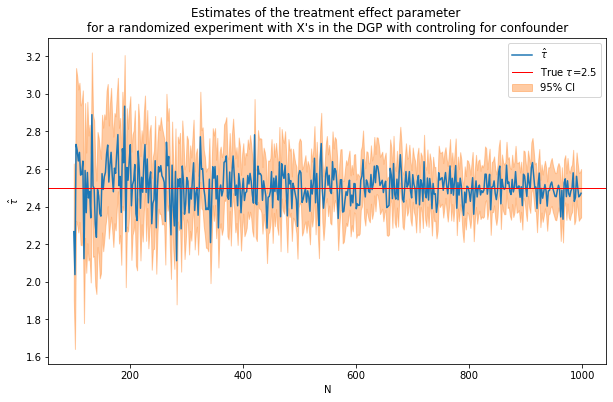

In [58]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP without controling selection varable"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

### Using a Monte Carlo experiment with sample sizes N=100 and N=1000, show the bias, RMSE and size of my treatment effect estimate in cases a and b.

#### (1). The Bias, RMSE and size of treatement effect in case a (control for the variable in between the path from cause to effect)

In [196]:
random.seed(10)
tau = 2.5
a = 0.5
b = 1.2
R = 1000
estDict = {}
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        e = np.random.normal(0,1,[N,1])
        T = fn_randomize_treatment(N)
        Y = tau*T+e
        X = a*Y+b*T+e
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]    
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 204.72it/s]


In [197]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.6333333333333333, RMSE=1.6333333333333333, size=1.0
N=1000: bias=-1.633333333333333, RMSE=1.6333333333333333, size=1.0


#### (1). The Bias, RMSE and size of treatement effect in case a (do not control for the variable in between the path from cause to effect)

In [171]:
random.seed(10)
tau = 2.5
a = 0.5
b = 1.2
R = 1000
estDict = {}
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        e = np.random.normal(0,1,[N,1])
        T = fn_randomize_treatment(N)
        Y = tau*T+e
        X = a*Y+b*T+e
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 220.64it/s]


In [172]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.008168331488732078, RMSE=0.20380713056382055, size=0.063
N=1000: bias=-0.0015471134411666866, RMSE=0.06167656205282664, size=0.04


### Example of a real-life situation

From above Monte Carlo experiment, we could find that when we generate data with treatment varaible and a selection variable, if we do not control for the selection variable, the bias and root mean squared error are much lower than the situation of controling for selection variable. So it's a harmful control.There are many real life situations like it, for example, we now need to estimate the effect of taking folic acid supplement A (1: yes, 0: no) for pregnant women shortly after conception on the risk Y (1: yes, 0: no) of the fetus developing cardiac malformations in the first two months of pregnancy. In addition, using variable C to indicate death before birth (1: yes, 0: no), cardiac malformation Y increases mortality C, while taking folic acid supplement A reduces the risk of malformations other than cardiac malformations, thereby reducing mortality C.If we don't control for variable C, then we can estimate the causal effect of A and Y by calculating the mean causal effect directly by calculating the difference between the mean outcomes of different treatment groups. However, suppose now that the data of fetuses that died before birth cannot be observed due to objective reasons, so the research is limited to the surviving fetuses (C=0), so C is controlled, because it is the common effect between A and Y, the new Bias was born from this.